In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import re
from tqdm import tqdm

def parse_name(path):
    name = os.path.basename(path)
    eta = float(re.search(r'eta(.*?)_', name).group(1))
    beta = float(re.search(r'beta(.*?)_', name).group(1))
    gamma = float(re.search(r'gamma(.*?)_', name).group(1))
    theta = float(re.search(r'theta(.*?)pi', name).group(1)) * np.pi
    r0 = float(re.search(r'ro(.*?)_', name).group(1))
    v0 = float(re.search(r'vo(.*?)_', name).group(1))
    return eta, beta, gamma, theta, r0, v0

In [246]:
root = '../sim/param_sweep/'

data = {key: [] for key in ['eta', 'beta', 'gamma', 'theta', 'r0', 'v0', 'ma', 'va', 'm', 'b']}
for path in tqdm(list(map(lambda x: os.path.join(root, x), os.listdir(root)))):
    eta, beta, gamma, theta, r0, v0 = parse_name(path)
    df = pd.read_csv(path)
    data['eta'].append(eta)
    data['beta'].append(beta)
    data['gamma'].append(gamma)
    data['theta'].append(theta)
    data['r0'].append(r0)
    data['v0'].append(v0)


    step = 800
    df = df[df.index > step]
    m, b = np.polyfit(df.va, df.ma, 1)

    data['m'].append(m)
    data['b'].append(b)

    data['ma'].append(df['ma'].mean())
    data['va'].append(df['va'].mean())
    
order_parameters = pd.DataFrame(data)

100%|██████████| 576/576 [00:00<00:00, 1473.39it/s]


10.0


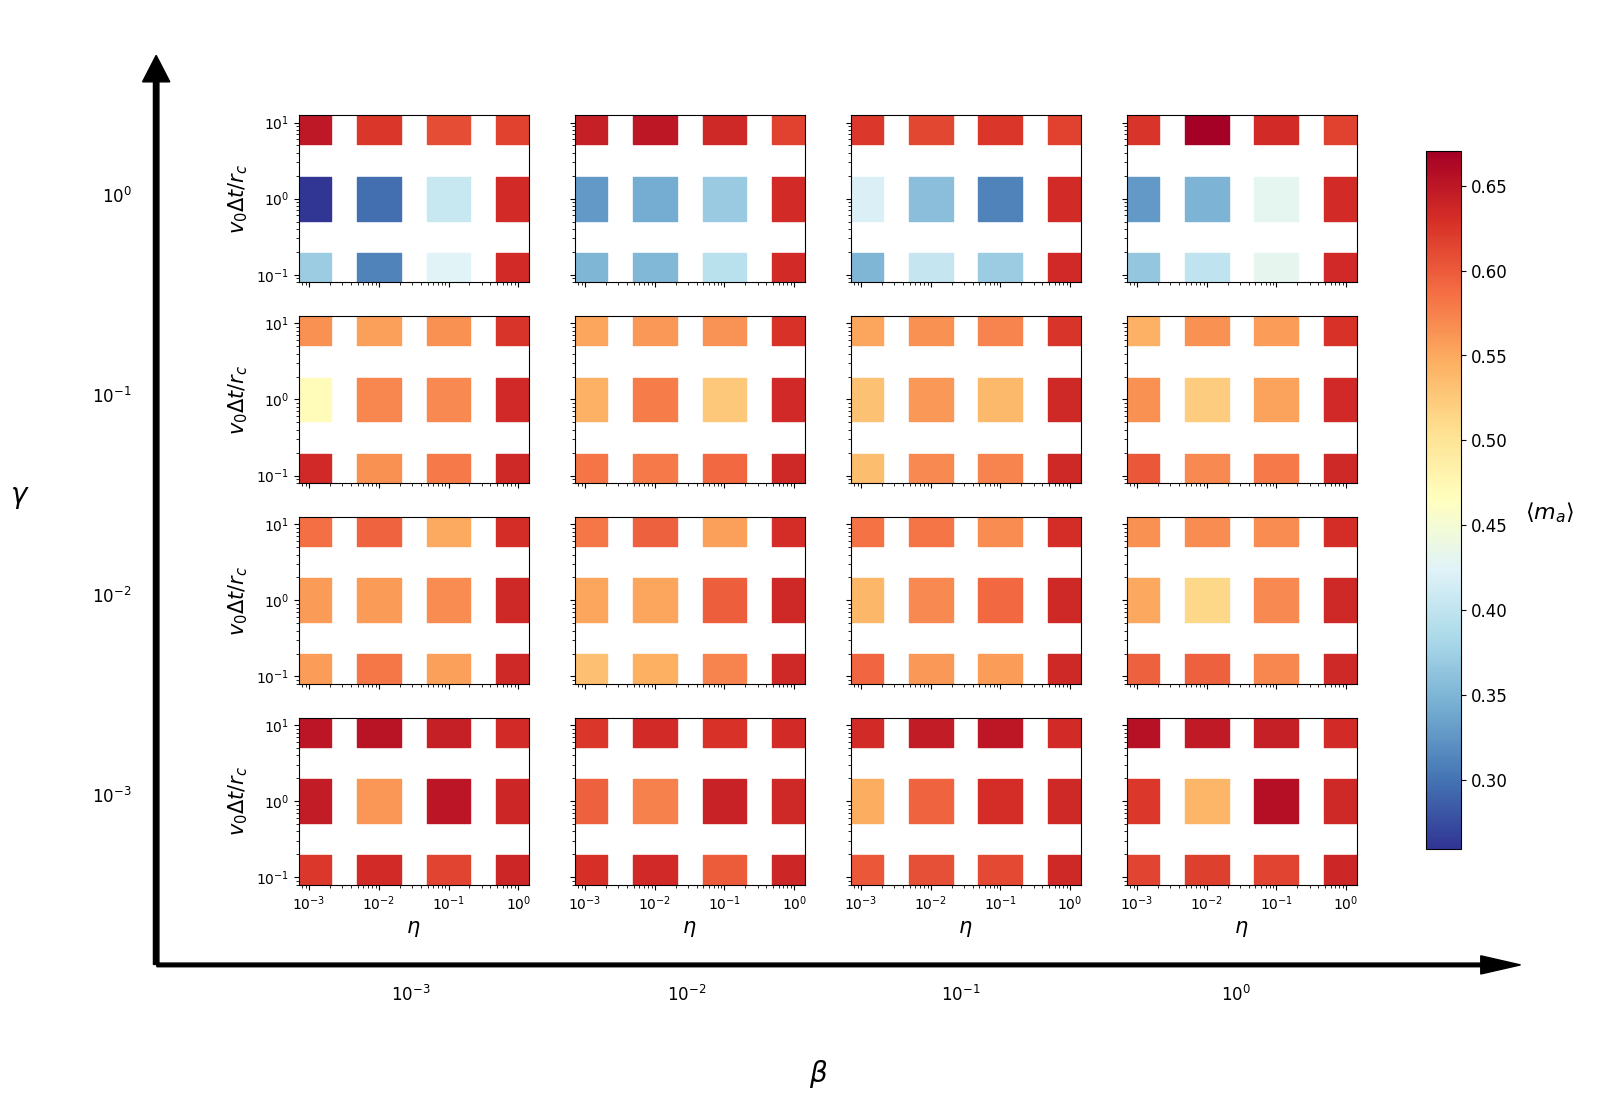

In [281]:
for theta in np.sort(order_parameters['theta'].unique()):
    break

for r0 in np.sort(order_parameters['r0'].unique()):
    if r0 == 2:
        print(r0)
        break

l1 = 10
l2 = 15
zlabel = 'ma'
zlabel_font = r'$\langle m_a \rangle$'
fig, axs = plt.subplots(order_parameters['gamma'].nunique(), order_parameters['beta'].nunique(), figsize=(l2, l1), sharex=True, sharey=True)

# Sorting the unique values
betas = np.sort(order_parameters['beta'].unique())
gammas = np.sort(order_parameters['gamma'].unique())

z = order_parameters[(order_parameters['theta'] == theta) & (order_parameters['r0'] == r0)][zlabel]

cmap = plt.cm.RdYlBu_r
norm = mcolors.Normalize(vmin=np.min(z), vmax=np.max(z))

# a = 0.5
# norm = mcolors.Normalize(vmin=np.mean(z) - np.std(z) * a, vmax=np.mean(z) + np.std(z) * a)

for i, gamma in enumerate(gammas[::-1]):
    for j, beta in enumerate(betas):
        # Selecting the subset of data
        sdf = order_parameters[(order_parameters['beta'] == beta) & (order_parameters['gamma'] == gamma) & (order_parameters['theta'] == theta) & (order_parameters['r0'] == r0)]

        z = sdf[zlabel]

        axs[i, j].scatter(sdf.eta, sdf.v0, c=cmap(norm(z)), s=1000, marker='s')
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')

        if i == len(gammas) - 1:
            axs[i, j].set_xlabel(r'$\eta$', fontsize=15)
        #     axs[i, j].set_xlabel(f'$\\beta$ = {beta}')
        if j == 0:
            axs[i, j].set_ylabel(r'$v_0 \Delta t / r_c$', fontsize=15)
        #     axs[i, j].set_ylabel(f'$\\gamma$ = {gamma}')
        

ax_shift = 0.015

tick_label_fontsize = 12  
axis_label_fontsize = 20

# Beta axis setup
beta_axis = fig.add_axes([-ax_shift, 0.02, 1, 0.02], frameon=False)
beta_axis.set_xticks([])
beta_axis.set_yticks([])
beta_axis.arrow(0.5, 0, 1, 0, head_width=0.005, head_length=0.03, fc='k', ec='k')
beta_axis.text(1.0, -0.03, '$\\beta$', ha='center', va='center', fontsize=axis_label_fontsize)

beta_axis_v = fig.add_axes([0.2, 0.02, 0.55, 0.02], frameon=False)
beta_axis_v.set_xscale('log')
beta_axis_v.set_xlim([np.min(betas), np.max(betas)])
beta_axis_v.set_xticks(betas)
beta_axis_v.set_yticks([])
beta_axis_v.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labelsize=tick_label_fontsize)

# Gamma axis setup
gamma_axis = fig.add_axes([0.02, -ax_shift, 0.02, 1], frameon=False)
gamma_axis.set_yticks([])
gamma_axis.set_xticks([])
gamma_axis.arrow(0, 0.5, 0, 1, head_width=0.005, head_length=0.03, fc='k', ec='k')
gamma_axis.text(-0.025, 1.03, '$\\gamma$', ha='center', va='center', rotation='horizontal', fontsize=axis_label_fontsize)

gamma_axis_v = fig.add_axes([0.02, 0.2, 0.02, 0.6], frameon=False)
gamma_axis_v.set_yscale('log')
gamma_axis_v.set_ylim([np.min(gammas), np.max(gammas)])
gamma_axis_v.set_yticks(gammas)
gamma_axis_v.set_xticks([])
gamma_axis_v.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, labelsize=tick_label_fontsize)

colorbar_label_fontsize = 16
colorbar_tick_fontsize = 12

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.03, pad=0.06)
cbar.set_label(zlabel_font, fontsize=colorbar_label_fontsize, rotation=0, labelpad=30)
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize) 
plt.savefig('sim_milling_order_parameter_theta{:.2f}_r0{:.2f}.png'.format(theta, r0), dpi=300, bbox_inches='tight')
plt.savefig('sim_milling_order_parameter_theta{:.2f}_r0{:.2f}.svg'.format(theta, r0), dpi=300, bbox_inches='tight')
plt.show()


# ma, va, ma * va, fit ma = f(va) and plot exponent to find similarity to birds



10.0


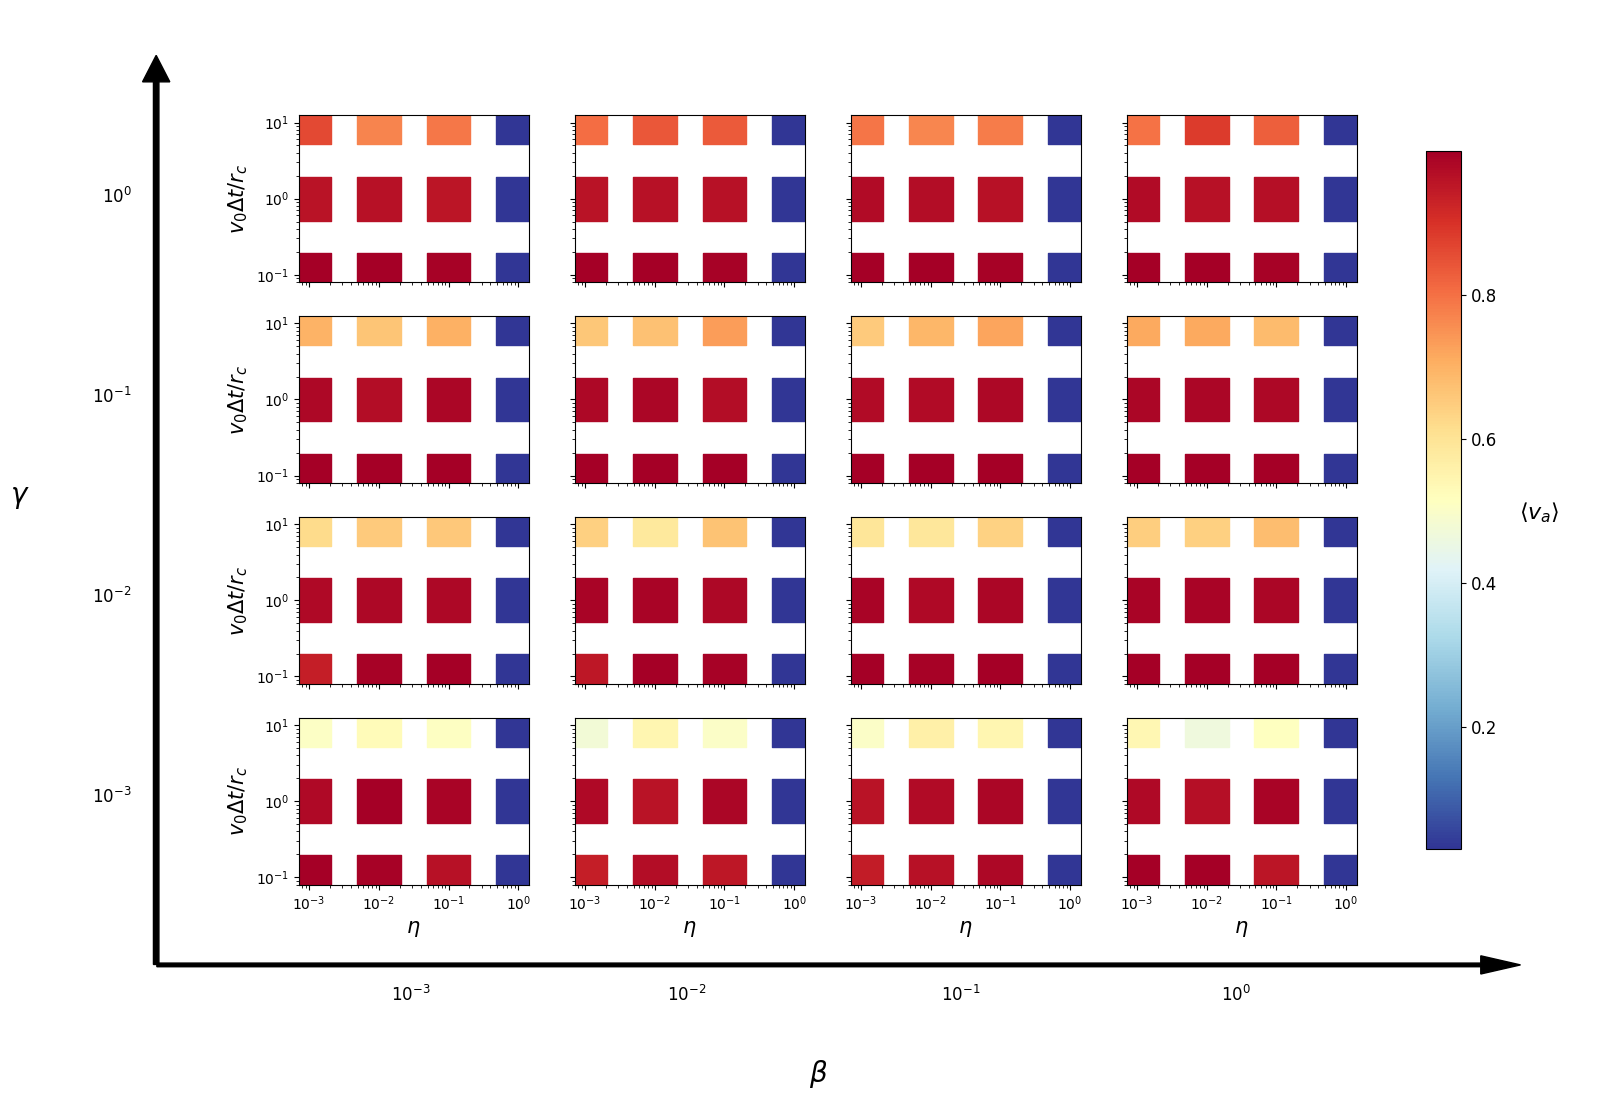

In [283]:
for theta in np.sort(order_parameters['theta'].unique()):
    break

for r0 in np.sort(order_parameters['r0'].unique()):
    if r0 == 2:
        print(r0)
        break

l1 = 10
l2 = 15
zlabel = 'va'
zlabel_font = r'$\langle v_a \rangle$'
fig, axs = plt.subplots(order_parameters['gamma'].nunique(), order_parameters['beta'].nunique(), figsize=(l2, l1), sharex=True, sharey=True)

# Sorting the unique values
betas = np.sort(order_parameters['beta'].unique())
gammas = np.sort(order_parameters['gamma'].unique())

z = order_parameters[(order_parameters['theta'] == theta) & (order_parameters['r0'] == r0)][zlabel]

cmap = plt.cm.RdYlBu_r
norm = mcolors.Normalize(vmin=np.min(z), vmax=np.max(z))

# a = 0.5
# norm = mcolors.Normalize(vmin=np.mean(z) - np.std(z) * a, vmax=np.mean(z) + np.std(z) * a)

for i, gamma in enumerate(gammas[::-1]):
    for j, beta in enumerate(betas):
        # Selecting the subset of data
        sdf = order_parameters[(order_parameters['beta'] == beta) & (order_parameters['gamma'] == gamma) & (order_parameters['theta'] == theta) & (order_parameters['r0'] == r0)]

        z = sdf[zlabel]

        axs[i, j].scatter(sdf.eta, sdf.v0, c=cmap(norm(z)), s=1000, marker='s')
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')

        if i == len(gammas) - 1:
            axs[i, j].set_xlabel(r'$\eta$', fontsize=15)
        #     axs[i, j].set_xlabel(f'$\\beta$ = {beta}')
        if j == 0:
            axs[i, j].set_ylabel(r'$v_0 \Delta t / r_c$', fontsize=15)
        #     axs[i, j].set_ylabel(f'$\\gamma$ = {gamma}')
        

ax_shift = 0.015

tick_label_fontsize = 12  
axis_label_fontsize = 20

# Beta axis setup
beta_axis = fig.add_axes([-ax_shift, 0.02, 1, 0.02], frameon=False)
beta_axis.set_xticks([])
beta_axis.set_yticks([])
beta_axis.arrow(0.5, 0, 1, 0, head_width=0.005, head_length=0.03, fc='k', ec='k')
beta_axis.text(1.0, -0.03, '$\\beta$', ha='center', va='center', fontsize=axis_label_fontsize)

beta_axis_v = fig.add_axes([0.2, 0.02, 0.55, 0.02], frameon=False)
beta_axis_v.set_xscale('log')
beta_axis_v.set_xlim([np.min(betas), np.max(betas)])
beta_axis_v.set_xticks(betas)
beta_axis_v.set_yticks([])
beta_axis_v.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labelsize=tick_label_fontsize)

# Gamma axis setup
gamma_axis = fig.add_axes([0.02, -ax_shift, 0.02, 1], frameon=False)
gamma_axis.set_yticks([])
gamma_axis.set_xticks([])
gamma_axis.arrow(0, 0.5, 0, 1, head_width=0.005, head_length=0.03, fc='k', ec='k')
gamma_axis.text(-0.025, 1.03, '$\\gamma$', ha='center', va='center', rotation='horizontal', fontsize=axis_label_fontsize)

gamma_axis_v = fig.add_axes([0.02, 0.2, 0.02, 0.6], frameon=False)
gamma_axis_v.set_yscale('log')
gamma_axis_v.set_ylim([np.min(gammas), np.max(gammas)])
gamma_axis_v.set_yticks(gammas)
gamma_axis_v.set_xticks([])
gamma_axis_v.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, labelsize=tick_label_fontsize)

colorbar_label_fontsize = 16
colorbar_tick_fontsize = 12

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.03, pad=0.06)
cbar.set_label(zlabel_font, fontsize=colorbar_label_fontsize, rotation=0, labelpad=30)
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize) 
plt.savefig('sim_velocity_order_parameter_theta{:.2f}_r0{:.2f}.png'.format(theta, r0), dpi=300, bbox_inches='tight')
plt.savefig('sim_velocity_order_parameter_theta{:.2f}_r0{:.2f}.svg'.format(theta, r0), dpi=300, bbox_inches='tight')
plt.show()


# ma, va, ma * va, fit ma = f(va) and plot exponent to find similarity to birds



In [285]:
for theta in np.sort(order_parameters['theta'].unique()):
    break

for r0 in np.sort(order_parameters['r0'].unique()):
    if r0 == 2:
        print(r0)
        break

l1 = 10
l2 = 15

zlabel_font = r'$\langle v_a \rangle \langle m_a \rangle$'
fig, axs = plt.subplots(order_parameters['gamma'].nunique(), order_parameters['beta'].nunique(), figsize=(l2, l1), sharex=True, sharey=True)

# Sorting the unique values
betas = np.sort(order_parameters['beta'].unique())
gammas = np.sort(order_parameters['gamma'].unique())

z = order_parameters[(order_parameters['theta'] == theta) & (order_parameters['r0'] == r0)]
z = z.ma * z.va

cmap = plt.cm.RdYlBu_r
norm = mcolors.Normalize(vmin=np.min(z), vmax=np.max(z))

# a = 0.5
# norm = mcolors.Normalize(vmin=np.mean(z) - np.std(z) * a, vmax=np.mean(z) + np.std(z) * a)

for i, gamma in enumerate(gammas[::-1]):
    for j, beta in enumerate(betas):
        # Selecting the subset of data
        sdf = order_parameters[(order_parameters['beta'] == beta) & (order_parameters['gamma'] == gamma) & (order_parameters['theta'] == theta) & (order_parameters['r0'] == r0)]

        z = sdf.ma * sdf.va

        axs[i, j].scatter(sdf.eta, sdf.v0, c=cmap(norm(z)), s=1000, marker='s')
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')

        if i == len(gammas) - 1:
            axs[i, j].set_xlabel(r'$\eta$', fontsize=15)
        #     axs[i, j].set_xlabel(f'$\\beta$ = {beta}')
        if j == 0:
            axs[i, j].set_ylabel(r'$v_0 \Delta t / r_c$', fontsize=15)
        #     axs[i, j].set_ylabel(f'$\\gamma$ = {gamma}')
        

ax_shift = 0.015

tick_label_fontsize = 12  
axis_label_fontsize = 20

# Beta axis setup
beta_axis = fig.add_axes([-ax_shift, 0.02, 1, 0.02], frameon=False)
beta_axis.set_xticks([])
beta_axis.set_yticks([])
beta_axis.arrow(0.5, 0, 1, 0, head_width=0.005, head_length=0.03, fc='k', ec='k')
beta_axis.text(1.0, -0.03, '$\\beta$', ha='center', va='center', fontsize=axis_label_fontsize)

beta_axis_v = fig.add_axes([0.2, 0.02, 0.55, 0.02], frameon=False)
beta_axis_v.set_xscale('log')
beta_axis_v.set_xlim([np.min(betas), np.max(betas)])
beta_axis_v.set_xticks(betas)
beta_axis_v.set_yticks([])
beta_axis_v.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labelsize=tick_label_fontsize)

# Gamma axis setup
gamma_axis = fig.add_axes([0.02, -ax_shift, 0.02, 1], frameon=False)
gamma_axis.set_yticks([])
gamma_axis.set_xticks([])
gamma_axis.arrow(0, 0.5, 0, 1, head_width=0.005, head_length=0.03, fc='k', ec='k')
gamma_axis.text(-0.025, 1.03, '$\\gamma$', ha='center', va='center', rotation='horizontal', fontsize=axis_label_fontsize)

gamma_axis_v = fig.add_axes([0.02, 0.2, 0.02, 0.6], frameon=False)
gamma_axis_v.set_yscale('log')
gamma_axis_v.set_ylim([np.min(gammas), np.max(gammas)])
gamma_axis_v.set_yticks(gammas)
gamma_axis_v.set_xticks([])
gamma_axis_v.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, labelsize=tick_label_fontsize)

colorbar_label_fontsize = 16
colorbar_tick_fontsize = 12

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.03, pad=0.06)
cbar.set_label(zlabel_font, fontsize=colorbar_label_fontsize, rotation=0, labelpad=50)
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize) 
plt.savefig('sim_product_order_parameter_theta{:.2f}_r0{:.2f}.png'.format(theta, r0), dpi=300, bbox_inches='tight')
plt.savefig('sim_product_order_parameter_theta{:.2f}_r0{:.2f}.svg'.format(theta, r0), dpi=300, bbox_inches='tight')
plt.show()


# ma, va, ma * va, fit ma = f(va) and plot exponent to find similarity to birds

# in presentation, start with one individual plot, explain it, then show the full diagram

10.0


In [ ]:
for theta in np.sort(order_parameters['theta'].unique()):
    break

for r0 in np.sort(order_parameters['r0'].unique()):
    if r0 == 2:
        print(r0)
        break

l1 = 10
l2 = 15
zlabel = 'ma'
zlabel_font = r'$\langle m_a \rangle$'
fig, axs = plt.subplots(order_parameters['gamma'].nunique(), order_parameters['beta'].nunique(), figsize=(l2, l1))

# Sorting the unique values
betas = np.sort(order_parameters['beta'].unique())
gammas = np.sort(order_parameters['gamma'].unique())

z = order_parameters[(order_parameters['theta'] == theta) & (order_parameters['r0'] == r0)][zlabel]

cmap = plt.cm.RdYlBu_r
norm = mcolors.Normalize(vmin=np.min(z), vmax=np.max(z))

for i, gamma in enumerate(gammas[::-1]):
    for j, beta in enumerate(betas):
        print(beta)
        # Selecting the subset of data
        sdf = order_parameters[(order_parameters['beta'] == beta) & (order_parameters['gamma'] == gamma) & (order_parameters['theta'] == theta) & (order_parameters['r0'] == r0)]

        z = sdf[zlabel]

        axs[i, j].scatter(sdf.eta, sdf.v0, c=cmap(norm(z)), s=1000, marker='s')
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')

        if i == len(gammas) - 1:
            axs[i, j].set_xlabel(r'$\eta$')
        #     axs[i, j].set_xlabel(f'$\\beta$ = {beta}')
        if j == 0:
            axs[i, j].set_ylabel(r'$v_0 \Delta t / r_c$')
        #     axs[i, j].set_ylabel(f'$\\gamma$ = {gamma}')
        

ax_shift = 0.015

beta_axis = fig.add_axes([-ax_shift, 0.02, 1, 0.02], frameon=False)
beta_axis.set_xticks([])
beta_axis.set_yticks([])
beta_axis.arrow(0.5, 0, 1, 0, head_width=0.005, head_length=0.03, fc='k', ec='k')
beta_axis.text(1.0, -0.03, '$\\beta$', ha='center', va='center', fontsize=16)

beta_axis_v = fig.add_axes([0.2, 0.02, 0.55, 0.02], frameon=False)
beta_axis_v.set_xscale('log')
beta_axis_v.set_xlim([np.min(betas), np.max(betas)])
beta_axis_v.set_xticks(betas)
beta_axis_v.set_yticks([])
beta_axis_v.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)


gamma_axis = fig.add_axes([0.02, -ax_shift, 0.02, 1], frameon=False)
gamma_axis.set_yticks([])
gamma_axis.set_xticks([])
gamma_axis.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)
gamma_axis.arrow(0, 0.5, 0, 1, head_width=0.005, head_length=0.03, fc='k', ec='k')
gamma_axis.text(-0.03, 1.03, '$\\gamma$', ha='center', va='center', rotation='vertical', fontsize=16)

gamma_axis_v = fig.add_axes([0.02, 0.2, 0.02, 0.6], frameon=False)
gamma_axis_v.set_yscale('log')
gamma_axis_v.set_ylim([np.min(gammas), np.max(gammas)])
gamma_axis_v.set_yticks(gammas)
gamma_axis_v.set_xticks([])
gamma_axis_v.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.03, pad=0.06, label=zlabel_font)
plt.show()


# ma, va, ma * va, fit ma = f(va) and plot exponent to find similarity to birds

